# A Cognitive Model or Harmonic Types - Clustering Experiment

The experiments in this notebook take a while to compute, so it is recommended to run them on a machine with GPU support (e.g. on Google Colab).

In [1]:
# if on google colab, uncomment and run the following line to install dependencies
# !pip install -r requirements.txt

In [2]:
# if on colab, run the following lines to mount your google drive
# from google.colab import drive
# drive._mount('/content/drive')

In [3]:
# set the data path to the directory where input data is stored under `./data`
# and results will be stored under `./results`.
data_path = "."

# use a path like this for google colab/drive:
# data_path = "/content/drive/Shareddrives/DCML/Projects/ERC/harmony-ornamentation"

In [4]:
import torch
import pyro
from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import tqdm
from IPython import display, get_ipython

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.special as special
import math

import os.path as path
from datetime import datetime
import json

import utils

import gc

/home/chfin/Uni/code/probabilistic_harmony_model/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# check if running in notebook or script
running_notebook = get_ipython() is not None
running_notebook

True

In [6]:
gpu = torch.cuda.is_available()

# TODO: set the GPU you want to use
gpu_n = 0

torch.set_default_dtype(torch.float64) # for numeric stability with large values

device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
device

device(type='cuda', index=0)

In [7]:
def debug_tensors():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) and obj.device == torch.device("cpu"):
            print(f"{obj.device}, {obj.dtype}, {obj.shape}")

debug_tensors()

cpu, torch.float32, torch.Size([])


/home/chfin/Uni/code/probabilistic_harmony_model/env/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:262: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


In [8]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [9]:
torch.set_default_dtype(torch.float64)

# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly
nclusters = 14                      # Try clustering down to how many clusters?

# 1. Experimental Setup

## Model

The model is identical to the base experiment except that several chord types can share a single parameter for the ornamentation prevalence. The sharing is controlled through the parameter `cluster_assignment`.

Additionally, a custom prefix can be used for the random varibles in the trace.
This allows us to run the same model function several times in a combined meta model.
We use this to compute the bayes factor between model variants with different chord type clustering.

In [10]:
def chord_model(npcs, nharmonies, cluster_assignment, data, pfx=None, subsamples=500, pobserve=0.5, **kwargs):
    if pfx is None or pfx == "":
        pfx = ""
    else:
        pfx += "_"
    nclusters = max(cluster_assignment) + 1
    # parameters priors:
    # distribution of the harmonies
    p_harmony = pyro.sample(f'{pfx}p_harmony', Dirichlet(0.5 * torch.ones(nharmonies, device=device)))
    # each cluster 
    with pyro.plate(f'{pfx}clusters', nclusters) as ind:
        # distribution of ornament probability
        p_is_chordtone = pyro.sample(f'{pfx}p_is_chordtone', Beta(torch.tensor(1., device=device),torch.tensor(1., device=device)))
    # distribution of notes in the harmonies
    with pyro.plate(f'{pfx}harmonies', nharmonies) as ind:
        #cluster = pyro.sample('cluster', Categorical(torch.ones(nclusters)))
        cluster = cluster_assignment[ind]
        p_is_chordtone_c = p_is_chordtone[cluster]
        #print(p_is_chordtone.shape)
        # distribution of notes per note type
        p_chordtones = pyro.sample(f'{pfx}p_chordtones', Dirichlet(0.5 * torch.ones(npcs, device=device)))
        p_ornaments  = pyro.sample(f'{pfx}p_ornaments', Dirichlet(0.5 * torch.ones(npcs, device=device)))
        #print(p_chordtones.shape)
        # we build a big categorical out of the chordtones and ornaments,
        # including notes of unknown type (marginalizing over the categories)
        #p_ct = p_is_chordtone_c       * p_chordtones
        #p_or = (1 - p_is_chordtone_c) * p_ornaments
        p_ct = torch.mm(torch.diag(p_is_chordtone_c), p_chordtones)
        p_or = torch.mm(torch.diag(1 - p_is_chordtone_c), p_ornaments)
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)
    # distribution of note rate in chords
    rate_notes = pyro.sample(f'{pfx}rate_notes', Gamma(torch.tensor(3., device=device),torch.tensor(1., device=device)))
    
    # sampling the data:
    nchords = len(data['c'])
    subs = min(nchords,subsamples) if subsamples != None else None
    with pyro.plate(f'{pfx}data', nchords, subsample_size=subs) as ind:
        # pick a harmony
        c = pyro.sample(f'{pfx}c', Categorical(p_harmony), obs=data['c'][ind])
        # pick a number of notes
        nnotes = 1 + pyro.sample(f'{pfx}n', Poisson(rate_notes), obs=data['n'][ind]).int()
        # sample chordtones
        # Normally we would sample nnotes notes for each chord, but that doesn't work vectorized.
        # However, evaluating the probability ignores n, so we can just provide 1 here.
        notes = pyro.sample(f'{pfx}chord', Multinomial(1, p_tones[c], validate_args=False), obs=data['notes'][ind])
        chords = {'c': c,
                  'n': nnotes,
                  'counts': notes.reshape(-1,npcs)}
    return chords

## Guide

A simple guide that assumes the latent variables to be distributed independently.

In [11]:
def chord_guide(npcs, nharmonies, cluster_assignment, data, pfx=None, subsamples=500, pobserve=0.5, init=dict(), optimize=True):
    if pfx is None or pfx == "":
        pfx = ""
    else:
        pfx += "_"
    nclusters = max(cluster_assignment) + 1
    
    # posterior of p_harmony
    params_p_harmony = init['harmonies'].to(device) if 'harmonies' in init else 0.5 * torch.ones(nharmonies, device=device)
    if optimize:
        params_p_harmony = pyro.param(f'{pfx}params_p_harmony',
                                      params_p_harmony,
                                      constraint=constraints.positive)
    pyro.sample(f'{pfx}p_harmony', Dirichlet(params_p_harmony))
    
    # posteriors of notes dists in harmonies (parameters)
    params_p_chordtones = init['chordtones'].to(device) if  'chordtones' in init else 0.5 * torch.ones(nharmonies, npcs, device=device)
    params_p_ornaments = init['ornaments'].to(device) if 'ornaments' in init else 0.5 * torch.ones(nharmonies, npcs, device=device)
    if optimize:
        params_p_chordtones = pyro.param(f'{pfx}params_p_chordtones',
                                         params_p_chordtones,
                                         constraint=constraints.positive)
        params_p_ornaments = pyro.param(f'{pfx}params_p_ornaments',
                                        params_p_ornaments,
                                        constraint=constraints.positive)
    
    # posterior of ornament probability (parameters)
    alpha_p_ict = init['is_ct'].to(device) if 'is_ct' in init else torch.ones(nclusters, device=device)
    beta_p_ict = init['is_or'].to(device) if 'is_or' in init else torch.ones(nclusters, device=device)
    if optimize:
        alpha_p_ict = pyro.param(f'{pfx}alpha_p_ict',
                                 alpha_p_ict,
                                 constraint=constraints.positive)
        beta_p_ict = pyro.param(f'{pfx}beta_p_ict',
                                beta_p_ict,
                                constraint=constraints.positive)
    
    with pyro.plate(f'{pfx}clusters', nclusters) as ind:
        pyro.sample(f'{pfx}p_is_chordtone', Beta(alpha_p_ict, beta_p_ict))
        
    # posteriors of ornament probability and note distributions
    with pyro.plate(f'{pfx}harmonies', nharmonies) as ind:
        pyro.sample(f'{pfx}p_chordtones', Dirichlet(params_p_chordtones[ind]))
        pyro.sample(f'{pfx}p_ornaments', Dirichlet(params_p_ornaments[ind]))
        
    #posterior of note rate
    alpha_rate_notes = init['sum_chords'].to(device) if 'sum_chords' in init else torch.tensor(3., device=device)
    beta_rate_notes = init['n_chords'].to(device) if 'n_chords' in init else torch.tensor(1., device=device)
    if optimize:
        alpha_rate_notes = pyro.param(f'{pfx}alpha_rate_notes',
                                      alpha_rate_notes,
                                      constraint=constraints.positive)
        beta_rate_notes = pyro.param(f'{pfx}beta_rate_notes',
                                     beta_rate_notes,
                                     constraint=constraints.positive)
    rate_notes = pyro.sample(f'{pfx}rate_notes', Gamma(alpha_rate_notes, beta_rate_notes))

## Data and Conditioning

### Data Format

Same as in the base experiment.

In [12]:
def chord_tensor(notes):
    """Takes a list of notes as (fifth, type) pairs and returns a vector of counts."""
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = torch.zeros((3, npcs), device=device)
    for (fifth, t) in notes:
      try:
        chord[notetype[t], utils.fifth_to_index(fifth)] += 1
      except Exception as e:
        print(fifth, utils.fifth_to_index(fifth))
        raise e
    return chord

def annot_data_obs(chords):
    """Helper function to turn a list of chord dictionary into a dictionary of observation vectors."""
    obs = {}
    obs["notes"] = torch.cat([chord_tensor(c['notes']).reshape((1,-1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1. for c in chords], device=device)
    return obs

### Loading the Dataset

The data is loaded from a TSV file that.
The resulting dataframe is converted to the observation format that we pass to the model.

In [13]:
chordtypes_common = np.array(
    ["major", "minor", "dominant-7th", "diminished",
     "full-diminished", "minor-7th", "half-diminished", "major-7th",
     "augmented"],
    dtype="object")
dcml_chordtype_map = {
    "M": "major",
    "m": "minor",
    "Mm7": "dominant-7th",
    "o": "diminished",
    "o7": "full-diminished",
    "mm7": "minor-7th",
    "%7": "half-diminished",
    "MM7": "major-7th",
    "+": "augmented",
    #"mM7": "minor-major-7th",
    #"+7": "augmented-7th",
}
wiki_chordtype_map = {
    "major": "major",
    "minor": "minor",
    "dominant": "dominant-7th",
    "diminished": "diminished",
    "diminished-seventh": "full-diminished",
    "minor-seventh": "minor-7th",
    "half-diminished": "half-diminished",
    "major-seventh": "major-7th",
    "augmented": "augmented",
    #"major-minor": "minor-major-7th",
    #"augmented-seventh": "augmented-7th",
}

In [14]:
def load_dataset(filename, alt_labels):
    filename = path.join(data_path, "data", filename)
    print("loading dataset...") 
    df = utils.load_csv(filename)
    df = df[df.label.map(lambda l: l in alt_labels)]
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)
    df['alt_label'] = df.label.map(alt_labels)
    
    # check if precomputed tensor data is available:
    prefn = filename + "_common_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
        obs["notes"] = obs["notes"].to(device)
        obs["c"] = obs["c"].to(device)
        obs["n"] = obs["n"].to(device)
        print(device)
        print([(k, v.device) for k, v in obs.items()])
    else:
        print('extracting chords...')
        chords = [{'label': label, 'notes': list(zip(grp.fifth, grp.type))}
                  for (_, label), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = annot_data_obs(chords)
        torch.save(obs, prefn)
    
    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, [alt_labels[l] for l in chordtypes]

It is important to initialize the posterior parameters with good guesses, close to their final values.
This function estimates the final values by ignoring unknown note types:

In [15]:
def get_init_params(df, nharms, npcs):
    init = dict()
    
    init['harmonies'] = torch.tensor(df.groupby('numlabel').size().sort_values(ascending=False), device=device) + 0.5

    init['chordtones'] = torch.zeros([nharms,npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df[df.type=='chordtone'].groupby(['numlabel','fifth']):
        init['chordtones'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()

    init['ornaments'] = torch.zeros([nharms,npcs], device=device) + 0.5
    for (numlabel, fifth), grp in df[df.type=='ornament'].groupby(['numlabel','fifth']):
        init['ornaments'][numlabel, utils.fifth_to_index(fifth)] += grp.fifth.count()
    
    init['is_ct'] = torch.tensor([sum(df[df.numlabel==l].type=='chordtone') for l in range(nharms)], device=device) + 1.
    init['is_or'] = torch.tensor([sum(df[df.numlabel==l].type=='ornament') for l in range(nharms)], device=device) + 1.
    
    chord_sizes = df.groupby('chordid').size()-1
    init['sum_chords'] = torch.tensor(sum(chord_sizes) + 3., device=device)
    init['n_chords'] = torch.tensor(len(chord_sizes) + 1., device=device)
    return init

After inferring the parameters we save them for easier inspection and reuse.

In [16]:
def save_params(params, chordtypes, name):
    torch.save(params, path.join(data_path, "results", "clustering", name+'.pt'))
    with open(path.join(data_path, "results", "clustering", name+'.json'), 'w') as f:
        json.dump({'params': {key: val.tolist() for key,val in params.items()},
                   'chordtypes': chordtypes},
                  f)

## Inference (per cluster)

Inference of the posterior is done via variational inference, i.e. by optimizing the parameters of the guide.
The function `infer_posteriors` takes a dataset of observations,
performs the optimization, and returns the optimized parameters together with some of their histories.

In [17]:
def infer_posteriors(obs, init, chordtypes, cluster_assignment,
                     nsteps=5_000, subsamples=10_000, particles=1,
                     plot_loss=True, save_as=None):
    # optimize the parameters of the guide
    pyro.clear_param_store()
    pyro.set_rng_seed(1625) # set every time for independent reproducibility
    svi = pyro.infer.SVI(model=chord_model,
                         guide=chord_guide,
                         optim=pyro.optim.Adam({"lr": 0.01, "betas": (0.95, 0.999)}),
                         #optim=pyro.optim.Adadelta({"lr": 1.0, "rho": 0.9}),
                         #optim=pyro.optim.SGD({"lr": 0.00005, "momentum": 0.9, "nesterov": True}),
                         loss=pyro.infer.Trace_ELBO(num_particles=particles))

    nharms = len(chordtypes)
    
    # set up histories for the loss and some of the parameters
    losses = np.zeros(nsteps)
    param_history = {name:np.zeros(nsteps) for name in ['alpha_rate_notes', 'beta_rate_notes']}#, 'alpha_p_ict', 'beta_p_ict']}
    root_history = np.zeros((nsteps,nharms))
    harm_history = np.zeros((nsteps,nharms))

    # run the optimization
    for i in tqdm.trange(nsteps):
        # update parameters and record loss
        losses[i] = svi.step(npcs, nharms, cluster_assignment, obs, subsamples=subsamples, init=init)
        
        # record values of some parameters
        ps = pyro.get_param_store()
        root_history[i] = ps.get_param('params_p_chordtones').cpu().detach()[:,fifth_range]
        harm_history[i] = ps.get_param('params_p_harmony').cpu().detach()
        for (name, value) in ps.items():
            if name in param_history:
                param_history[name][i] = value.cpu().item()

    # plot the loss
    if plot_loss:
        plt.figure()
        plt.plot(losses)
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.title(f'loss ({save_as})')
        plt.show(block=False)
    print("loss variance (last 100 steps):", losses[-100:].var())
    
    params = dict((name, value.detach().cpu().detach().numpy()) for name, value in pyro.get_param_store().items())
    if save_as != None:
        save_params(params, chordtypes, save_as)
    
    return params, param_history, root_history, harm_history, losses

We can use different distance measures for deciding which clusters to merge. By default, we will use the distance between the corresponding distributions' means (`mean_dist`).

In [18]:
def clust_dist(X,Y):
    return 1 - (special.beta((X[0] + Y[0]) / 2, (X[1] + Y[1]) /2)) / math.sqrt(special.beta(X[0],X[1]) * special.beta(Y[0],Y[1]))

def mean_dist(X,Y):
    return abs(stats.beta.mean(X[0],X[1]) - stats.beta.mean(Y[0],Y[1]))

The clustering itself is performed iteratively, like in hierarchical clustering.
Initially, each chord type is its own cluster.
In every iteration, the two clusters with the most similar posteriors of `p_ict` are merged. 

In [19]:
def iterative_clustering(init, chordtypes, obs, name, dist=mean_dist, show_plots=True):
    nharms = len(chordtypes)

    # initial clustering
    cluster_assignment = dict((i,i) for i in range(nharms))

    # run iterative experiments
    outputs = []
    for it in range(nharms):
        nclusters = nharms - it
        print(f"iteration {it} ({nclusters} clusters).")
        print(cluster_assignment)
        
        # inference
        assignment = torch.tensor([cluster_assignment[i] for i in range(nharms)], device=device)
        params, hist, roots, harm, loss = infer_posteriors(obs, init, chordtypes, assignment,
                                                           nsteps=350, subsamples=None, particles=1,
                                                           save_as=f"{name}_params{nclusters}",
                                                           plot_loss=False)
        # record output
        outputs.append(dict({
            "params": params,
            "hist": hist,
            "roots": roots,
            "harm": harm,
            "cluster_assignment": cluster_assignment,
            "init": init,
        }))
        
        if show_plots:
            plot_histories(f"{name}, {nclusters} clusters", hist, roots, harm, loss)
            #plot_p_ict(params, chordtypes, cluster_assignment, lower=0.6, upper=0.95)
        
        # compute next clustering / init
        if nclusters > 1:
            # find closest clusters
            alphas = params["alpha_p_ict"]
            betas = params["beta_p_ict"]
            dists = dict()
            for i in range(nclusters):
                for j in range(i+1, nclusters):
                    dists[(i,j)] = dist((alphas[i], betas[i]), (alphas[j], betas[j]))
            min1, min2 = min(dists, key=dists.get)

            # map clusters
            remaining = [i for i in range(nclusters) if i not in [min1,min2]]
            cluster_mapping = {**{min1: 0, min2: 0}, **dict((c,i+1) for i,c in enumerate(remaining))}
            
            # update assignment
            cluster_assignment = dict((h,cluster_mapping[c]) for h,c in cluster_assignment.items())

            # update init
            # ... with the posterior parameters from the previous run
            init = dict()
            init['harmonies'] = torch.tensor(params['params_p_harmony'], device=device)
            init['chordtones'] = torch.tensor(params['params_p_chordtones'], device=device)
            init['ornaments'] = torch.tensor(params['params_p_ornaments'], device=device)
            init['sum_chords'] = torch.tensor(params['alpha_rate_notes'], device=device)
            init['n_chords'] = torch.tensor(params['beta_rate_notes'], device=device)
            # ... and merged clusters
            init['is_ct'] = torch.zeros(nclusters-1, dtype=torch.float64, device=device)
            init['is_or'] = torch.zeros(nclusters-1, dtype=torch.float64, device=device)
            for i in range(nclusters-1):
                init['is_ct'][i] += alphas[cluster_mapping[i]]
                init['is_or'][i] += betas[cluster_mapping[i]]

    return outputs

## Bayes Factor Inference

To find the best cluster assignment, we perform a Bayesian model comparison between the different assignments found by the iterative clustering algorithm.
This is achieved by considering each assignment as a "sub-model" in a meta model.
The full (meta-)model first picks a sub-model $m$ (= cluster assignment) and generates the data from this model:
$$ p(D) = p(m) \cdot p(D \mid m). $$
The posterior probabilities of this "model choice" express the relative plausibility of each cluster assignment.
The base factor between two models $m_1$ and $m_2$ is
$$ \dfrac{p(D \mid m_1)}{p(D \mid m_2)} = \dfrac{p(m_1 \mid D)}{p(m_2 \mid D)} \dfrac{m_2}{m_1}. $$
However, we use a flat prior over the model choice, so $\dfrac{m_2}{m_1} = 1$.

In [20]:
def post_to_init(params):
    init = dict()
    init['harmonies'] = torch.tensor(params['params_p_harmony'], device=device)
    init['chordtones'] = torch.tensor(params['params_p_chordtones'], device=device)
    init['ornaments'] = torch.tensor(params['params_p_ornaments'], device=device)
    init['sum_chords'] = torch.tensor(params['alpha_rate_notes'], device=device)
    init['n_chords'] = torch.tensor(params['beta_rate_notes'], device=device)
    init['is_ct'] = torch.tensor(params['alpha_p_ict'], device=device)
    init['is_or'] = torch.tensor(params['beta_p_ict'], device=device)
    return init

In [21]:
def replay_clustering(name, nharms, dist=mean_dist):
    # initial clustering
    cluster_assignment = dict((i,i) for i in range(nharms))

    # run iterative experiments
    outputs = []
    
    for it in range(nharms):
        nclusters = nharms - it
        print(f"iteration {it} ({nclusters} clusters).")
        print(cluster_assignment)
        
        # inference
        params_load = torch.load(path.join(data_path, "params", f"{name}_params{nclusters}.pt"), map_location=device)
        params = dict((n, torch.tensor(vals, device=device)) for n, vals in params_load.items())
        
        # record output
        outputs.append(dict({
            "params": params,
            "cluster_assignment": cluster_assignment,
        }))
        
        # compute next clustering / init
        if nclusters > 1:
            # find closest clusters
            alphas = params["alpha_p_ict"]
            betas = params["beta_p_ict"]
            dists = dict()
            for i in range(nclusters):
                for j in range(i+1, nclusters):
                    dists[(i,j)] = dist((alphas[i], betas[i]), (alphas[j], betas[j]))
            min1, min2 = min(dists, key=dists.get)

            # map clusters
            remaining = [i for i in range(nclusters) if i not in [min1,min2]]
            cluster_mapping = {**{min1: 0, min2: 0}, **dict((c,i+1) for i,c in enumerate(remaining))}
            
            # update assignment
            cluster_assignment = dict((h,cluster_mapping[c]) for h,c in cluster_assignment.items())

    return outputs

In [22]:
def bf_meta_model(npcs, nharms, cluster_assignments, data, **kwargs):
    nmodels = len(cluster_assignments)
    m = pyro.sample("model", Categorical(torch.ones(nmodels, device=device) / nmodels))
    if m.dim() == 0:
        return chord_model(npcs, nharms, cluster_assignments[m], data, **kwargs, pfx=f"m{m}")
    else:
        for i in m:
            chord_model(npcs, nharms, cluster_assignments[i], data, **kwargs, pfx=f"m{i}")

def bf_meta_guide(npcs, nharmonies, cluster_assignments, data, inits, **kwargs):
    nmodels = len(cluster_assignments)
    params_model = pyro.param("params_model", torch.ones(nmodels, device=device) / nmodels, constraint=constraints.simplex)
    m = pyro.sample("model", Categorical(params_model), infer={'enumerate': 'sequential'})
    chord_guide(npcs, nharmonies, cluster_assignments[m], data,
                pfx=f"m{m}", init=inits[m], optimize=False, **kwargs)

In [23]:
def bf_infer_model_posterior(obs, outputs, chordtypes,
                             nsteps=5_000, subsamples=10_000, particles=1, lr=0.01,
                             plot_loss=True, save_as=None):
    # optimize the parameters of the guide
    pyro.clear_param_store()
    pyro.set_rng_seed(1625) # set every time for independent reproducibility
    svi = pyro.infer.SVI(model=bf_meta_model,
                         guide=bf_meta_guide,
                         optim=pyro.optim.Adam({"lr": lr, "betas": (0.95, 0.999)}),
                         #optim=pyro.optim.Adadelta({"lr": 1.0, "rho": 0.9}),
                         #optim=pyro.optim.SGD({"lr": 0.00005, "momentum": 0.9, "nesterov": True}),
                         loss=pyro.infer.TraceEnum_ELBO(num_particles=particles))

    nharms = len(chordtypes)
    nmodels = len(outputs)
    assignments = [torch.tensor([outputs[m]['cluster_assignment'][i] for i in range(nharms)], device=device)
                           for m in range(nmodels)]
    inits = [post_to_init(outputs[i]['params']) for i in range(nmodels)]
    
    # set up histories for the loss and some of the parameters
    losses = np.zeros(nsteps)
    param_history = np.zeros((nsteps,nmodels))
    
    # run the optimization
    for i in tqdm.trange(nsteps):
        # update parameters and record loss
        losses[i] = svi.step(npcs, nharms, assignments, obs, inits=inits, subsamples=subsamples)
        
        # record values of some parameters
        ps = pyro.get_param_store()
        param_history[i] = ps.get_param(f'params_model').cpu().detach()

        if (plot_loss and (i % 10 == 0) and running_notebook):
          display.clear_output(wait=True)
          plot_bf_history(save_as, losses[:i+1], param_history[:i+1])

    # plot the final loss and history
    if plot_loss:
        plot_bf_history(save_as, losses, param_history)
    print("loss variance (last 100 steps):", losses[-100:].var())
    
    params = dict((name, value.cpu().detach().numpy()) for name, value in pyro.get_param_store().items())
    if save_as != None:
        save_params(params, chordtypes, save_as)
    
    return params, param_history

In [24]:
def bf_bayes_factors(params):
    params = params['params_model']
    nmodels = len(params)
    bfs = np.array([[params[i] / params[j] for j in range(nmodels)] for i in range(nmodels)])
    return bfs, params

def plot_bayes_factors(bfs, probs):
    nclusters = len(probs)
    labels = list(range(nclusters, 0, -1))

    sns.heatmap(bfs,
                xticklabels=labels, yticklabels=labels,
                norm=LogNorm(vmin=bfs.min(), vmax=bfs.max()), center=0)
    plt.show(block=False)
    sns.barplot(x=labels, y=probs)
    plt.show(block=False)

In [25]:
def run_bayes_factors(obs, outputs, chordtypes, nsteps=500, lr=0.01, save_as=None):
    params, hist = bf_infer_model_posterior(obs, outputs, chordtypes,
                                            nsteps=nsteps, subsamples=None, particles=1, lr=lr,
                                            plot_loss=True, save_as=save_as)
    return params, hist

In [26]:
def run_bayes_factors_mcmc(obs, outputs, chordtypes, nsamples=1_000, nwarmup=None, jit=False, chains=1):
    if nwarmup is None:
        nwarmup = nsamples
    
    nuts_kernel = pyro.infer.NUTS(bf_meta_model, jit_compile=jit)
    mcmc = pyro.infer.MCMC(nuts_kernel,
                           num_samples=nsamples,
                           warmup_steps=nwarmup,
                           num_chains=chains)
    
    nharms = len(chordtypes)
    nmodels = len(outputs)
    assignments = [torch.tensor([outputs[m]['cluster_assignment'][i] for i in range(nharms)], device=device)
                           for m in range(nmodels)]
    
    mcmc.run(npcs, nharms, assignments, obs, subsamples=None)
    return mcmc

In [27]:
#dcml_mcmc = run_bayes_factors_mcmc(dcml_obs, dcml_outputs, dcml_chordtypes, nsamples=1)
#dcml_mcmc.summary()

## Plotting

To inspect the results and the behaviour of the optimization, we define some functions for plotting parameter histories and posterior distributions.

In [28]:
# histories

# several parameters
def plot_params_history(ax, history):
    df = pd.DataFrame(history)
    df.plot(ax=ax)
    ax.set_title(f"history")
    ax.set_xlabel("iteration")
    
# single parameter
def plot_param_history(title, ax, root_history):
    ax.plot(root_history)
    ax.set_xlabel("iteration")
    ax.set_title(title)

# all parameters
def plot_histories(name, param_history, root_history, harm_history, loss):
    fig, ax = plt.subplots(2, 2, figsize=(9,6))
    plot_param_history('loss', ax[0,0], loss)
    plot_params_history(ax[0,1], param_history)
    plot_param_history('root parameters', ax[1,0], root_history)
    plot_param_history('chord-type parameters', ax[1,1], harm_history)
    fig.suptitle(name)
    fig.tight_layout()
    plt.show(block=False)
    
# bayes factor
def plot_bf_history(name, losses, param_history):
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    plot_param_history("loss", ax[0], losses)
    plot_param_history("model probabilities", ax[1], param_history)
    fig.suptitle(f"Bayes factor histories ({name})")
    fig.tight_layout()
    plt.show(block=False)

In [29]:
# posteriors

def plot_p_ict_cluster(name, ax, params, harmtypes, cluster_assignment, lower=0, upper=1):
    alphas = params["alpha_p_ict"]
    betas  = params["beta_p_ict"]
    means = alphas / (alphas + betas)
    
    # compute cluster names from assignment
    names = dict() # cluster index -> list of chord types
    for chord, cluster in cluster_assignment.items():
        label = harmtypes[chord]
        if(names.get(cluster) == None):
            names[cluster] = []
        names[cluster].append(label)
    # sort by cluster index
    its = sorted(names.items())
    name_labels = [str.join(", ",it[1]) for it in its]
    
    # combine all data and sort by cluster mean
    data = pd.DataFrame({"alpha": alphas, "beta": betas, "names": name_labels, "mean": means})
    data = data.sort_values("mean")
    x = np.linspace(lower, upper, 600)
    y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(data.alpha, data.beta)]).transpose()
    
    # plot
    ax.plot(x,y)
    ax.set_xlabel(f"$\\theta$ ({len(set(cluster_assignment.values()))} clusters)")
    ax.legend(data.names, bbox_to_anchor=(0.5, 1.1),
              loc='lower center', ncols=(len(data.names)-1)//3 + 1)
    ax.set_title(f"posteriors of 'p_is_chordtone' ({name}, {len(data.names)} clusters)")

def plot_clusters(name, outputs, chordtypes, lower, upper):
    fig, axs = plt.subplots(9, 1, figsize=(9,30))
    for output, ax in zip(outputs, axs):
        plot_p_ict_cluster(name, ax, output['params'], chordtypes, output['cluster_assignment'], lower, upper)
    fig.tight_layout()
    plt.show(block=False)

# 2. Experiments

## Clustering (DCML Corpus)

The DCML corpus is a collection of classical pieces with elaborate harmonic annotations.
Here we only distinguish the basic harmonic types defined in the annotation standard (triads and seventh chords),
since the extra information (inversion, suspensions, added notes etc.) do not change the type of the chord.

In [30]:
# prepare the dataset
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv', dcml_chordtype_map)

loading dataset...
extracting chords...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112774/112774 [00:04<00:00, 23660.44it/s]


converting chords to tensors...
9 chord types
112774 chords


In [31]:
dcml_chordtypes

['major',
 'dominant-7th',
 'minor',
 'diminished',
 'full-diminished',
 'minor-7th',
 'half-diminished',
 'major-7th',
 'augmented']

In [32]:
dcml_init = get_init_params(dcml_df, len(dcml_chordtypes), npcs)

In [33]:
print(dcml_chordtypes)
#print(dcml_init)
#for init in dcml_inits:
#    print(init['cluster'])

['major', 'dominant-7th', 'minor', 'diminished', 'full-diminished', 'minor-7th', 'half-diminished', 'major-7th', 'augmented']


iteration 0 (9 clusters).
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 17.77it/s]


loss variance (last 100 steps): 3855.132354971182


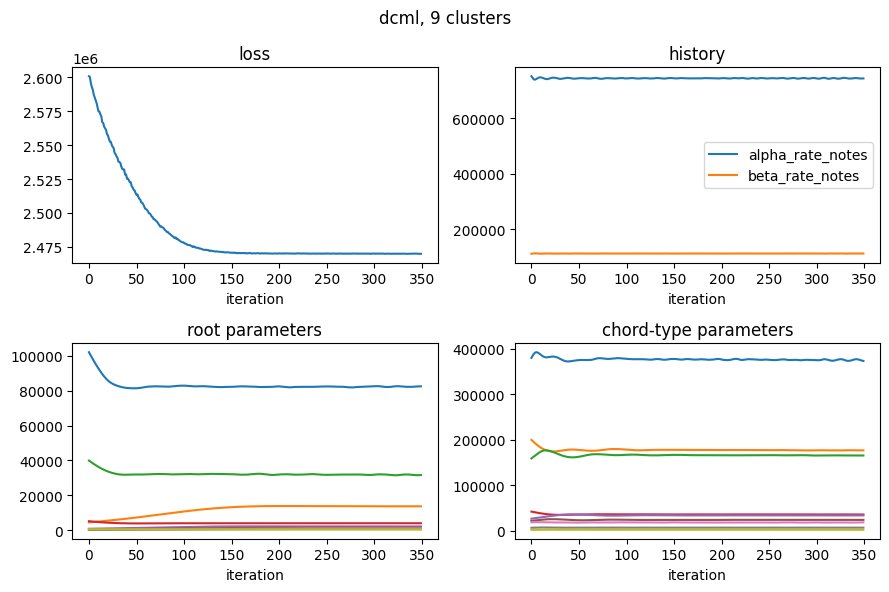

iteration 1 (8 clusters).
{0: 1, 1: 0, 2: 2, 3: 3, 4: 0, 5: 4, 6: 5, 7: 6, 8: 7}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 18.16it/s]


loss variance (last 100 steps): 378.11437254578215


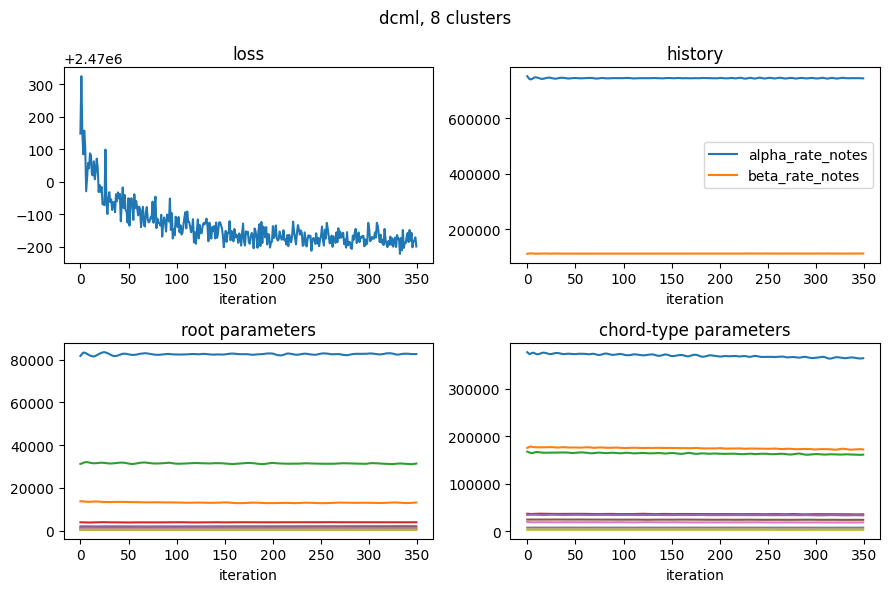

iteration 2 (7 clusters).
{0: 0, 1: 1, 2: 2, 3: 3, 4: 1, 5: 4, 6: 0, 7: 5, 8: 6}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 18.04it/s]


loss variance (last 100 steps): 350.1906002965715


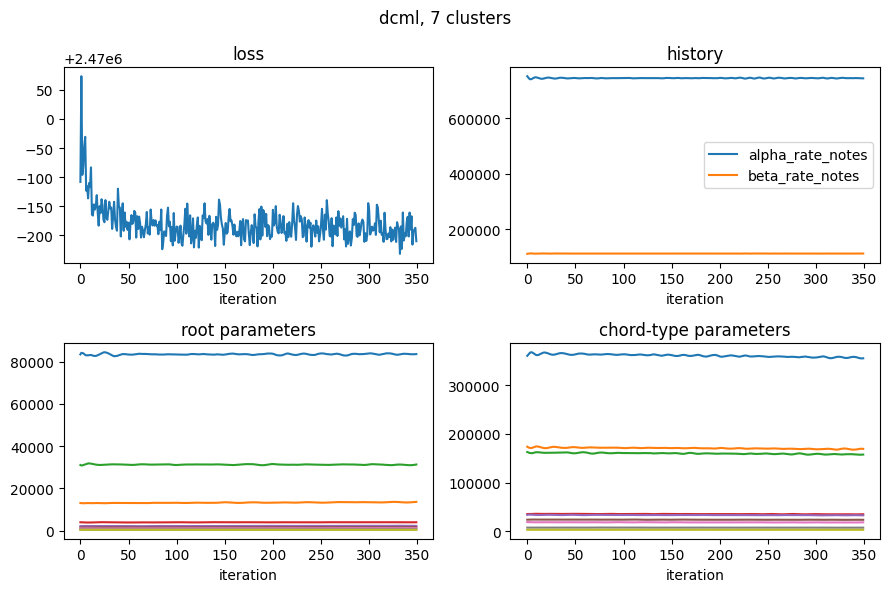

iteration 3 (6 clusters).
{0: 1, 1: 2, 2: 0, 3: 3, 4: 2, 5: 0, 6: 1, 7: 4, 8: 5}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 18.04it/s]


loss variance (last 100 steps): 318.966575764717


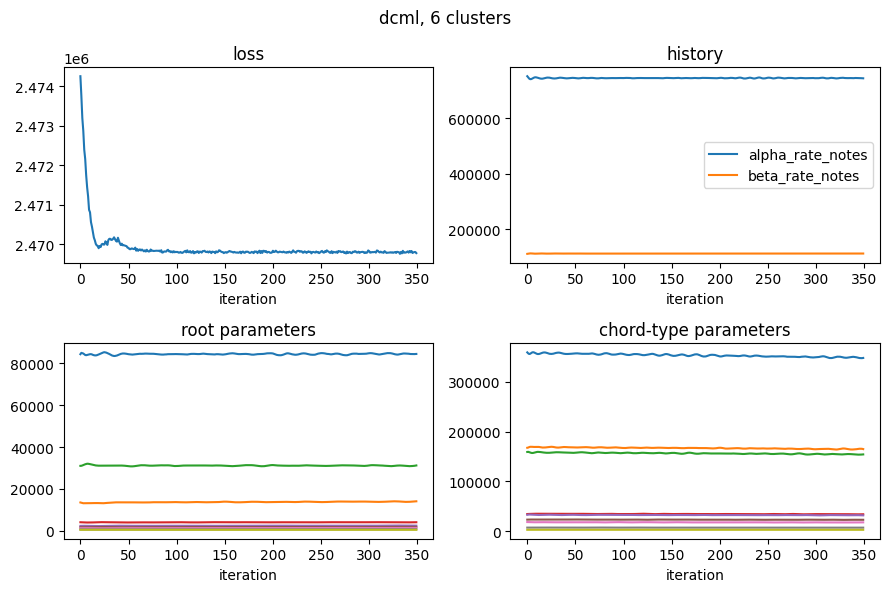

iteration 4 (5 clusters).
{0: 0, 1: 2, 2: 1, 3: 3, 4: 2, 5: 1, 6: 0, 7: 0, 8: 4}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 18.04it/s]


loss variance (last 100 steps): 304.9231296754379


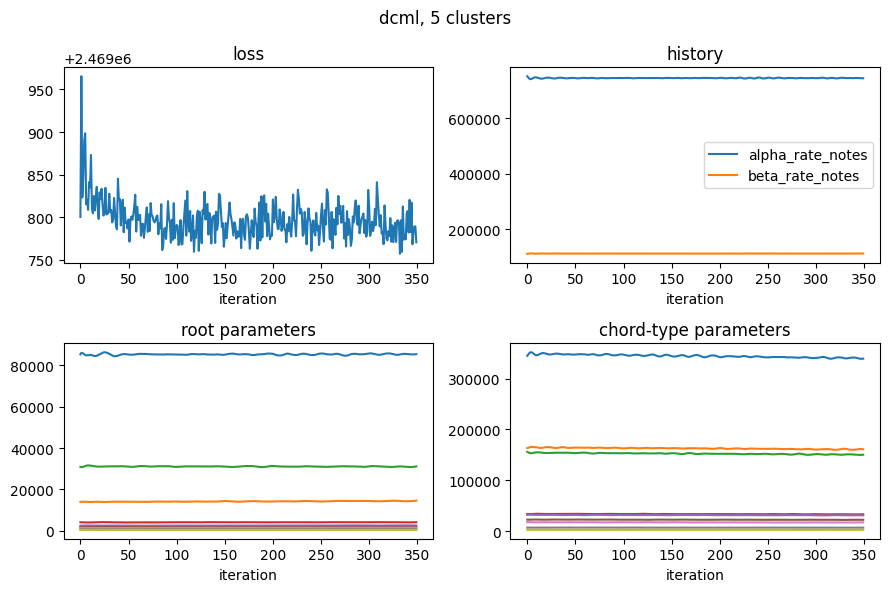

iteration 5 (4 clusters).
{0: 0, 1: 1, 2: 0, 3: 2, 4: 1, 5: 0, 6: 0, 7: 0, 8: 3}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 18.26it/s]


loss variance (last 100 steps): 289.5035145331936


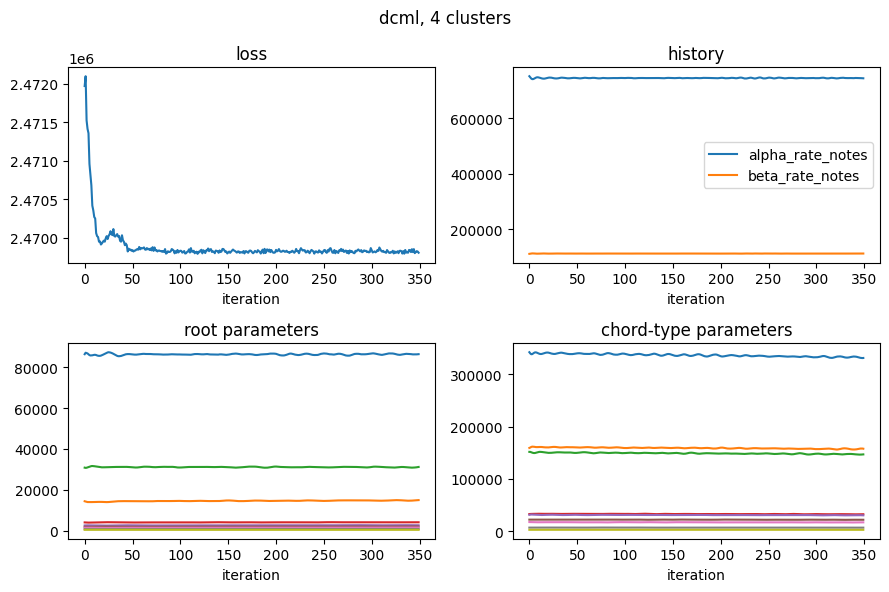

iteration 6 (3 clusters).
{0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 2}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 18.10it/s]


loss variance (last 100 steps): 267.3538617628991


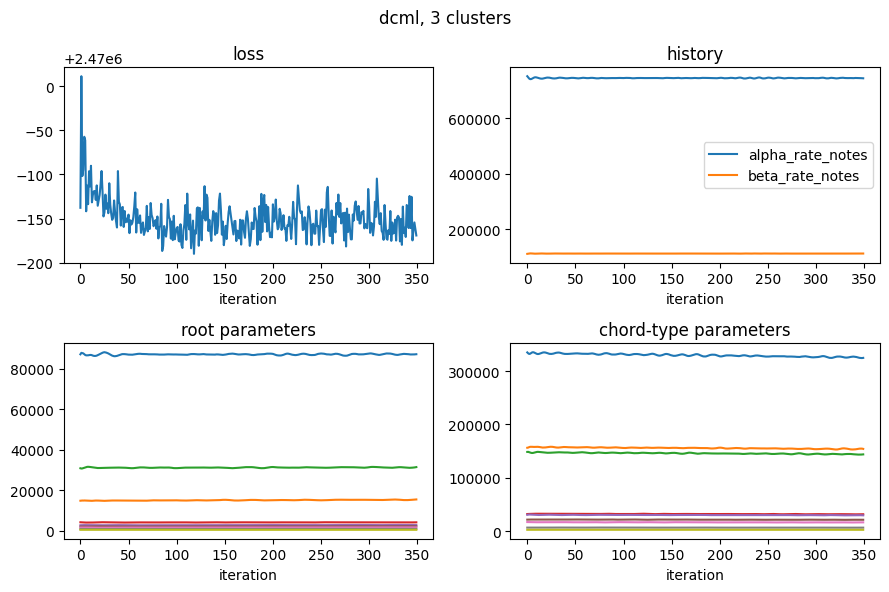

iteration 7 (2 clusters).
{0: 0, 1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 18.08it/s]


loss variance (last 100 steps): 246.87856538820378


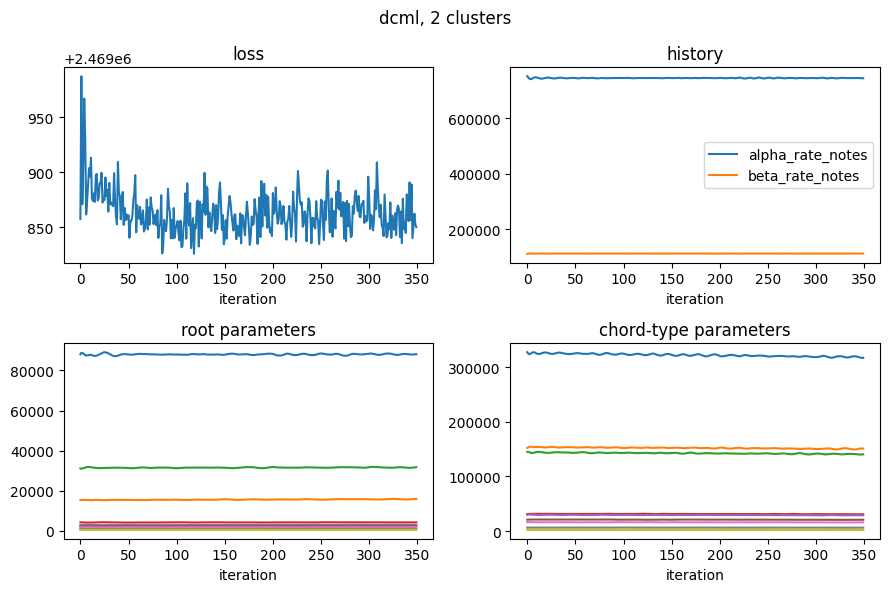

iteration 8 (1 clusters).
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:19<00:00, 18.07it/s]


loss variance (last 100 steps): 218.33124157621427


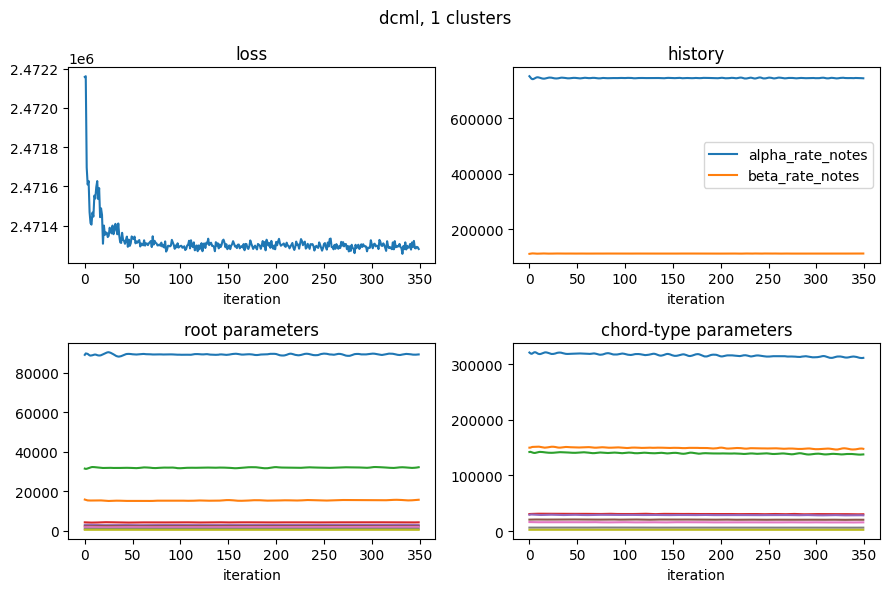

In [34]:
dcml_outputs = iterative_clustering(dcml_init, dcml_chordtypes, dcml_obs, "dcml")

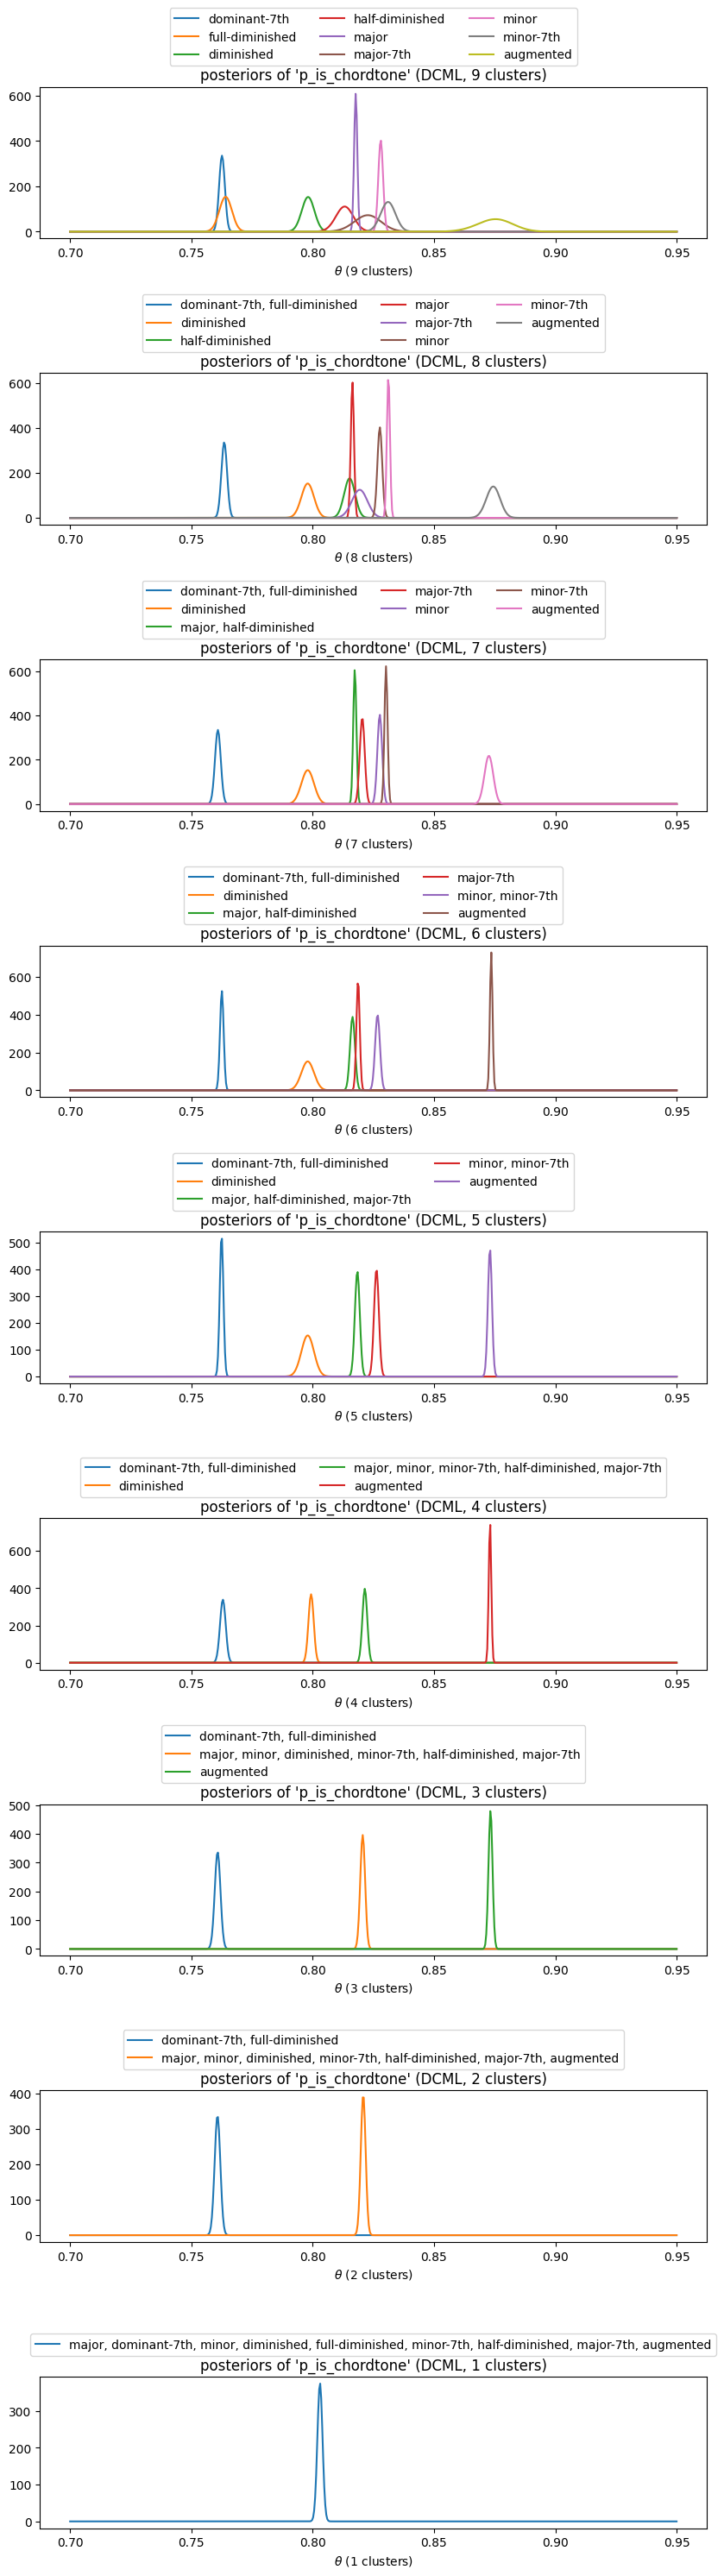

In [35]:
plot_clusters("DCML", dcml_outputs, dcml_chordtypes, lower=0.7, upper=0.95)

## Bayes Factor (DCML)

In [36]:
# reload the data (optional, can be used to skip the clustering)
# dcml_outputs = replay_clustering("dcml", 11)

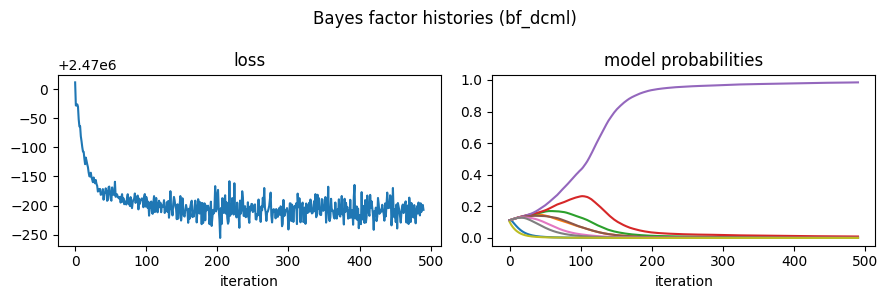

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:24<00:00,  2.45it/s]


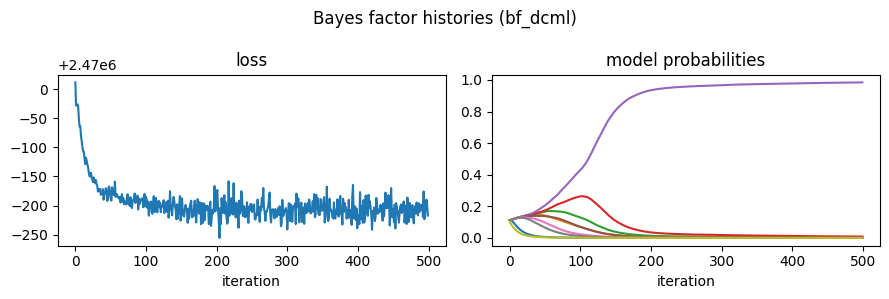

loss variance (last 100 steps): 215.37208022321363


In [37]:
dcml_cmp, dcml_cmp_hist = run_bayes_factors(dcml_obs, dcml_outputs, dcml_chordtypes, nsteps=500, lr=0.05, save_as="bf_dcml")

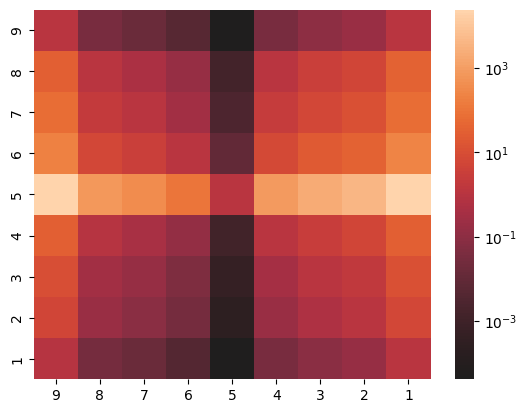

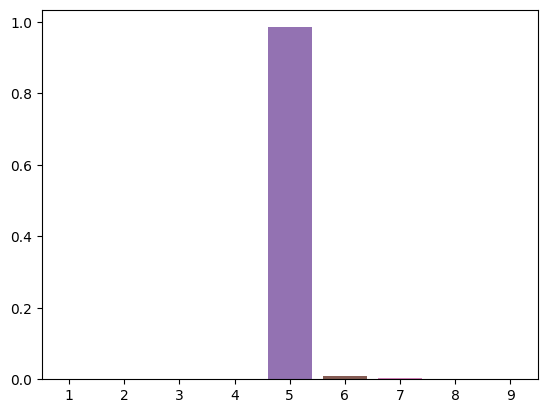

0.8929878232647345

In [38]:
dcml_bfs, dcml_m_params = bf_bayes_factors(dcml_cmp)
plot_bayes_factors(dcml_bfs, dcml_m_params)
dcml_bfs[8,0]

## Clustering (EWLD Corpus)

EWLD is a large subset of Wikifonia, so it shares the same format.

In [39]:
# prepare the dataset
ewld_df, ewld_obs, ewld_chordtypes = load_dataset('ewld.tsv', wiki_chordtype_map)
ewld_init = get_init_params(ewld_df, len(ewld_chordtypes), npcs)

loading dataset...
extracting chords...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 173727/173727 [00:07<00:00, 24096.10it/s]


converting chords to tensors...
9 chord types
173727 chords


In [40]:
print(ewld_chordtypes)
#for init in wiki_inits:
    #print(init['cluster'])

['major', 'dominant-7th', 'minor', 'minor-7th', 'major-7th', 'diminished', 'half-diminished', 'full-diminished', 'augmented']


iteration 0 (9 clusters).
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:26<00:00, 13.00it/s]


loss variance (last 100 steps): 100.23344192851513


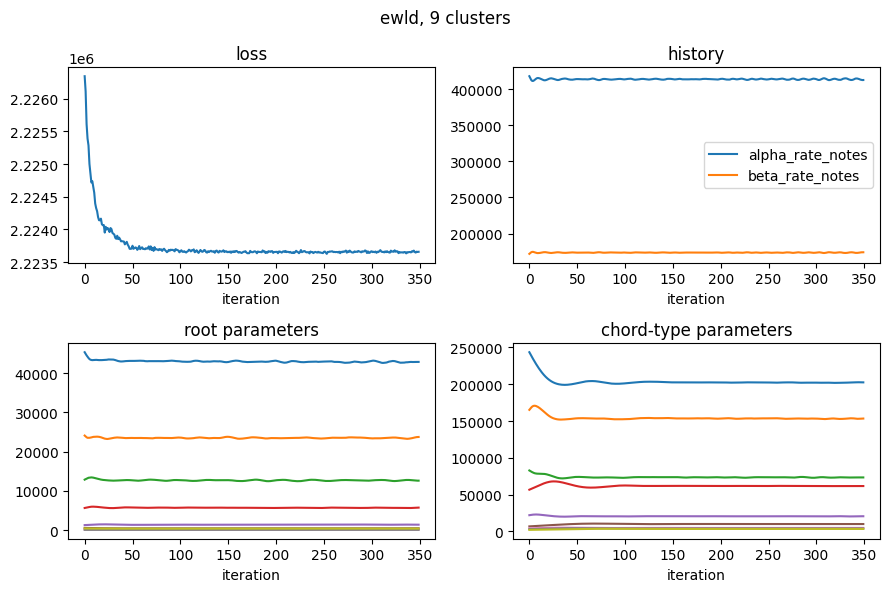

iteration 1 (8 clusters).
{0: 0, 1: 1, 2: 0, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:26<00:00, 13.00it/s]


loss variance (last 100 steps): 102.47549881579192


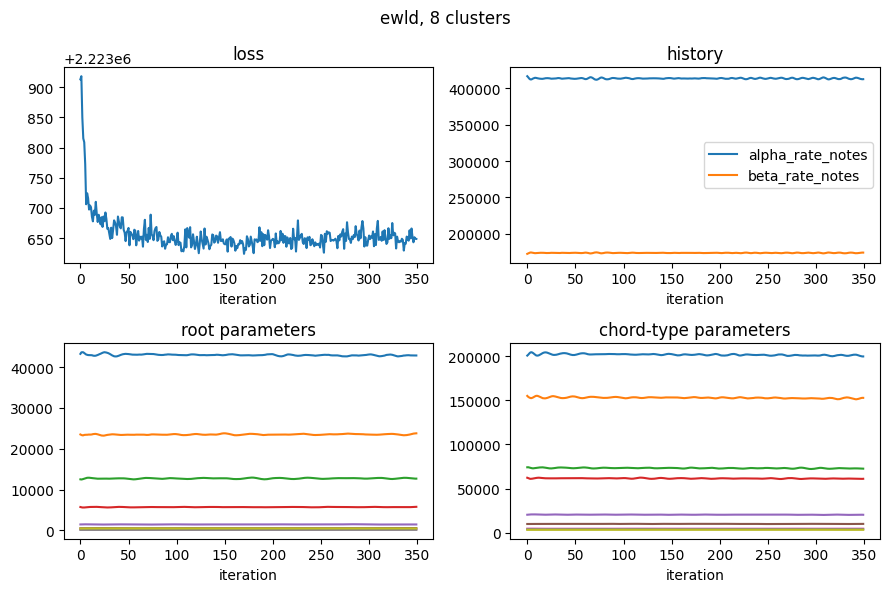

iteration 2 (7 clusters).
{0: 1, 1: 2, 2: 1, 3: 0, 4: 3, 5: 4, 6: 0, 7: 5, 8: 6}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:26<00:00, 13.16it/s]


loss variance (last 100 steps): 95.28495283036038


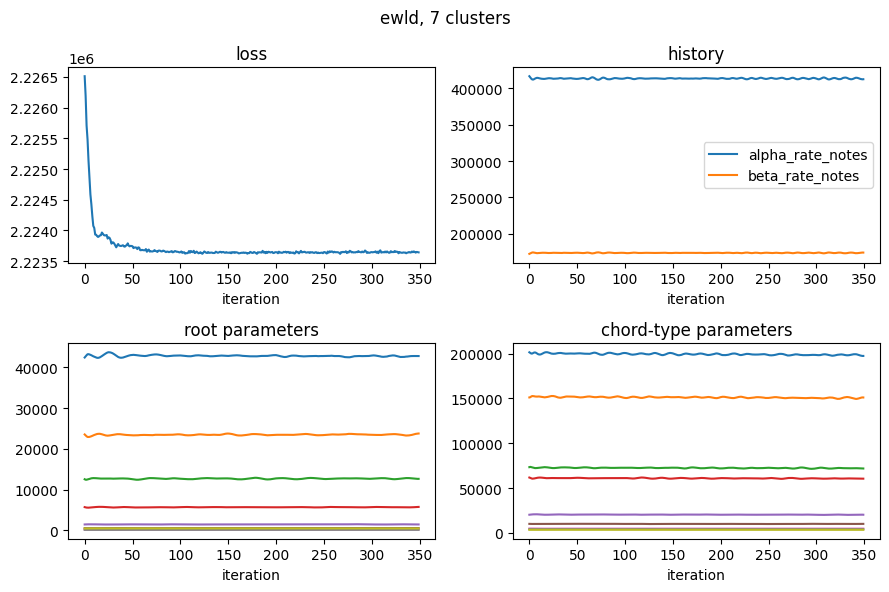

iteration 3 (6 clusters).
{0: 0, 1: 2, 2: 0, 3: 1, 4: 0, 5: 3, 6: 1, 7: 4, 8: 5}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:26<00:00, 13.16it/s]


loss variance (last 100 steps): 95.06480688081768


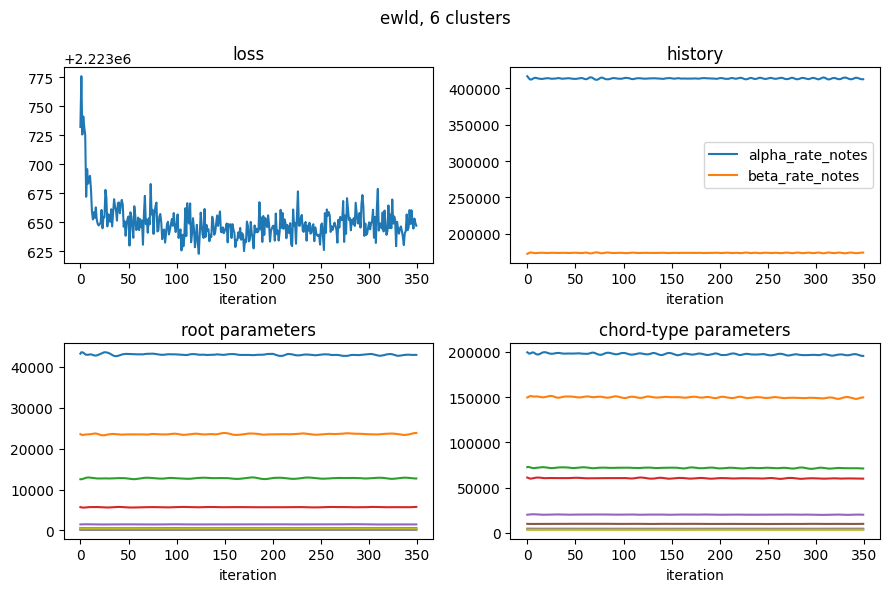

iteration 4 (5 clusters).
{0: 1, 1: 3, 2: 1, 3: 2, 4: 1, 5: 0, 6: 2, 7: 0, 8: 4}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:26<00:00, 13.14it/s]


loss variance (last 100 steps): 88.08153084993045


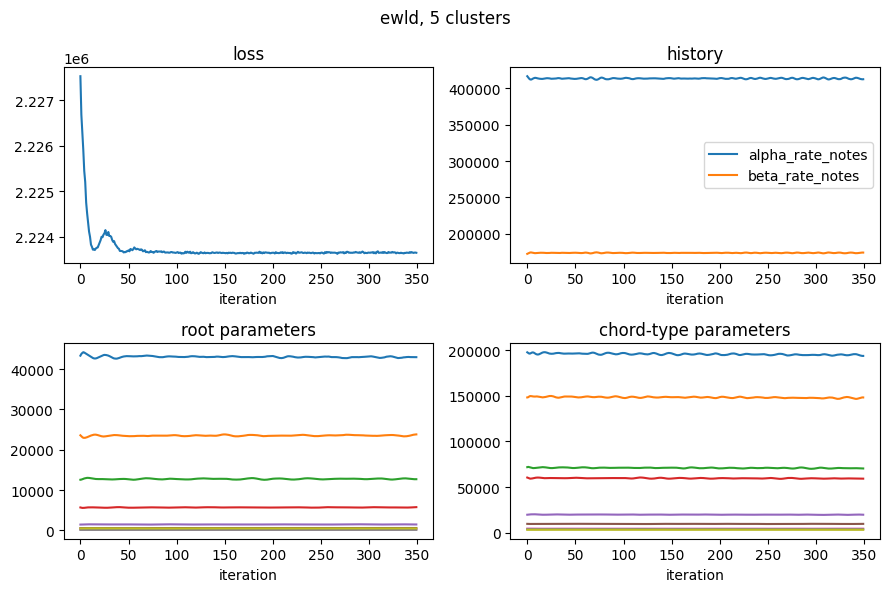

iteration 5 (4 clusters).
{0: 1, 1: 3, 2: 1, 3: 2, 4: 1, 5: 0, 6: 2, 7: 0, 8: 0}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:26<00:00, 13.02it/s]


loss variance (last 100 steps): 85.77471764476823


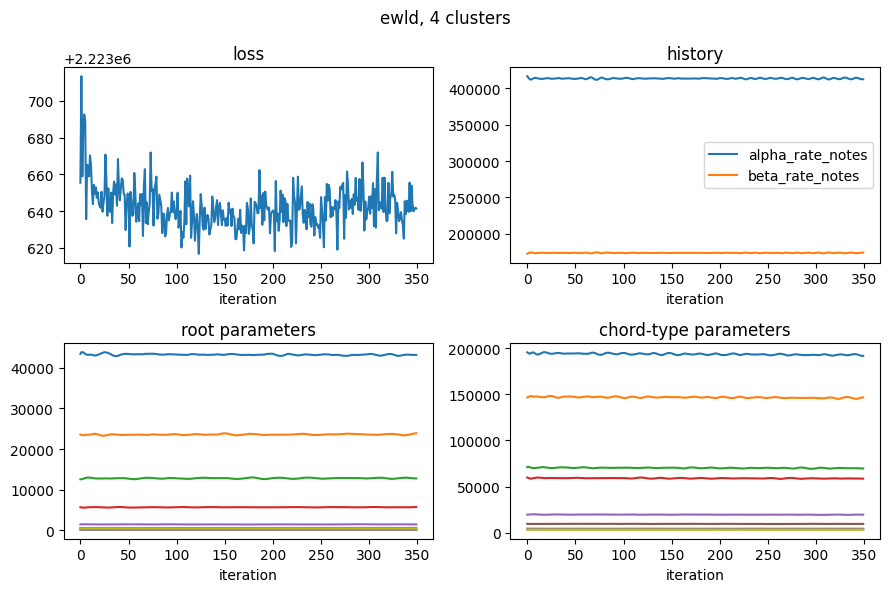

iteration 6 (3 clusters).
{0: 0, 1: 2, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:26<00:00, 12.99it/s]


loss variance (last 100 steps): 87.78856088665802


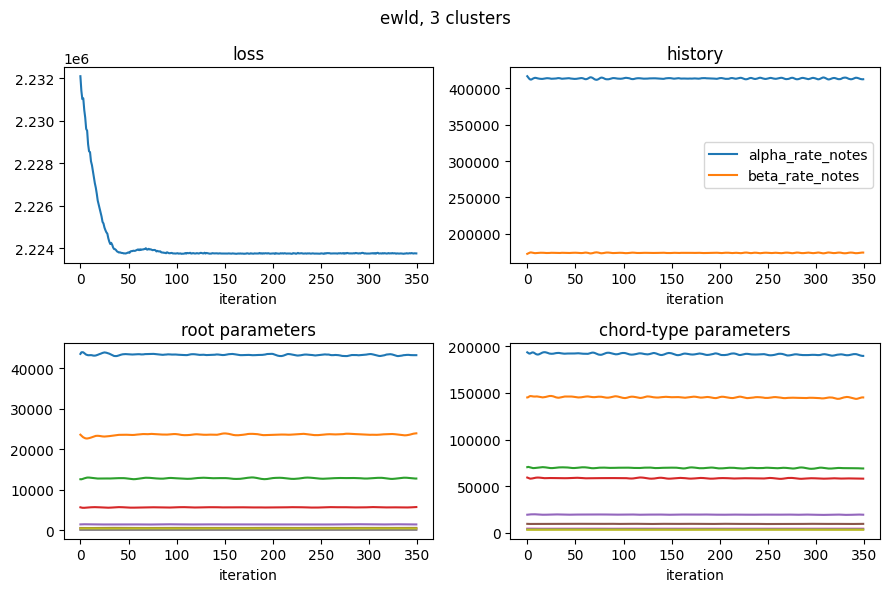

iteration 7 (2 clusters).
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 1, 8: 1}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:26<00:00, 13.00it/s]


loss variance (last 100 steps): 102.13555113448149


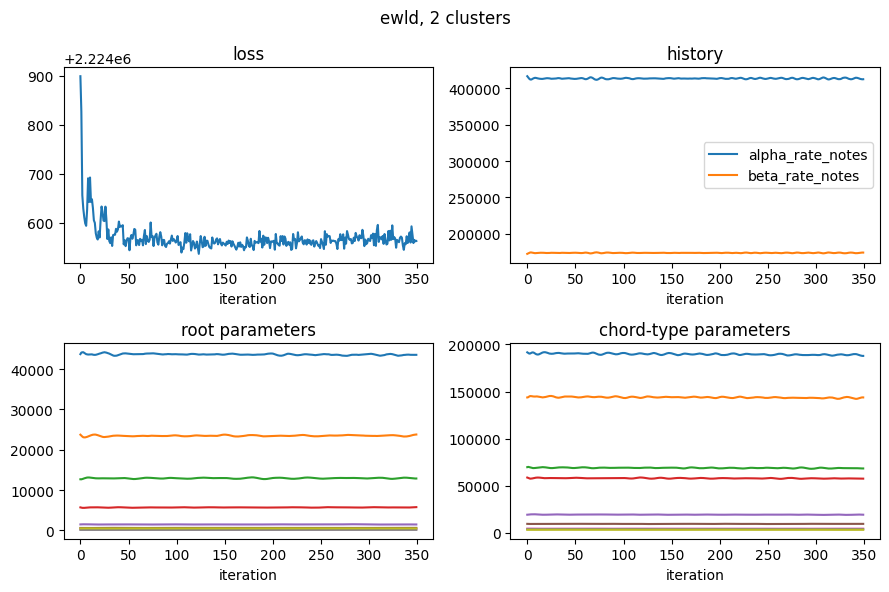

iteration 8 (1 clusters).
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:26<00:00, 13.05it/s]


loss variance (last 100 steps): 89.79032496352478


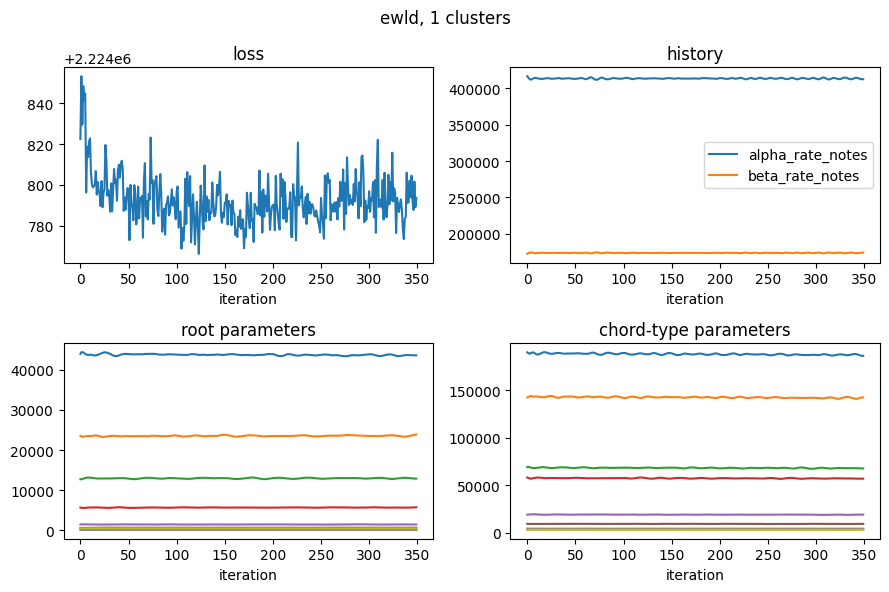

In [41]:
ewld_outputs = iterative_clustering(ewld_init, ewld_chordtypes, ewld_obs, "ewld")

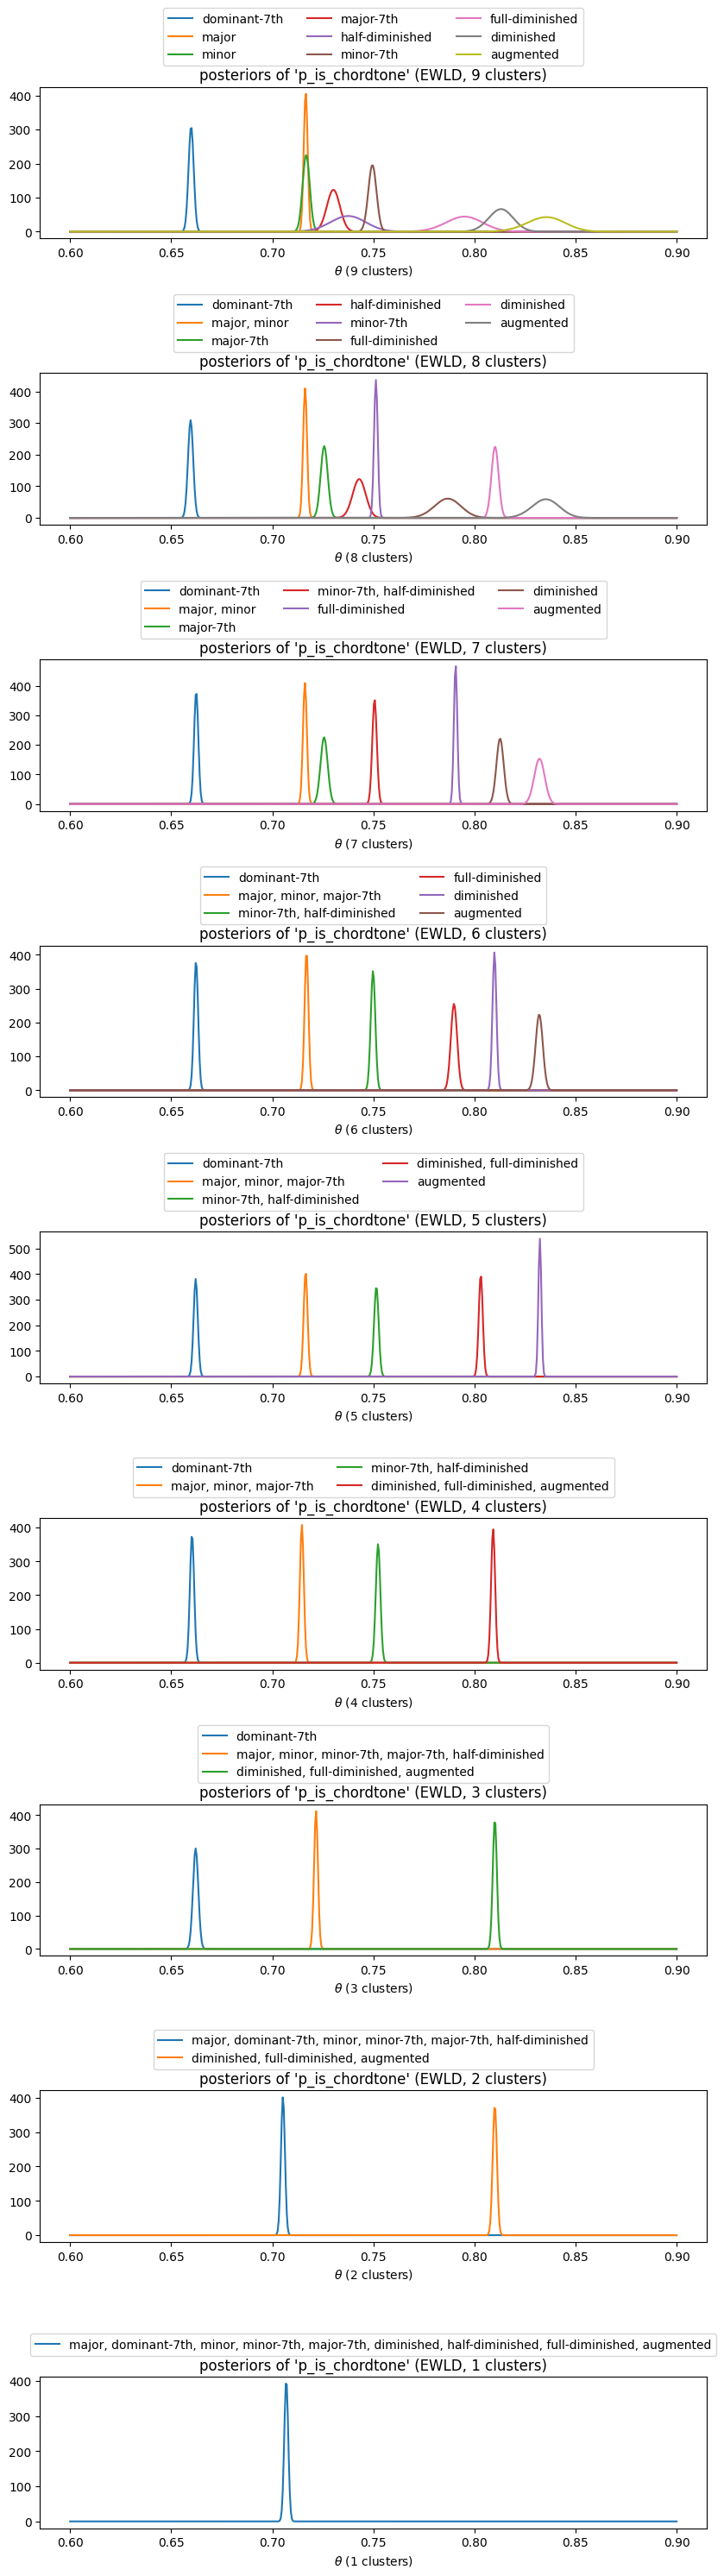

In [42]:
# plot the posterior distributions of the parameters
plot_clusters("EWLD", ewld_outputs, ewld_chordtypes, lower=0.6, upper=0.9)
# for output in ewld_outputs:
#     plot_p_ict(output['params'], ewld_chordtypes, output['cluster_assignment'], lower=0.65, upper=0.95)

## Bayes Factor (EWLD)

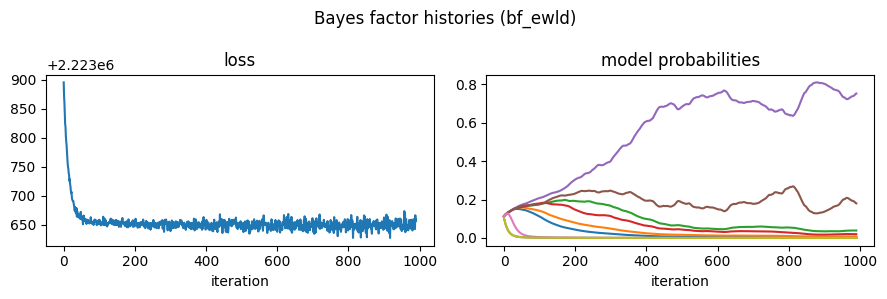

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:36<00:00,  1.74it/s]


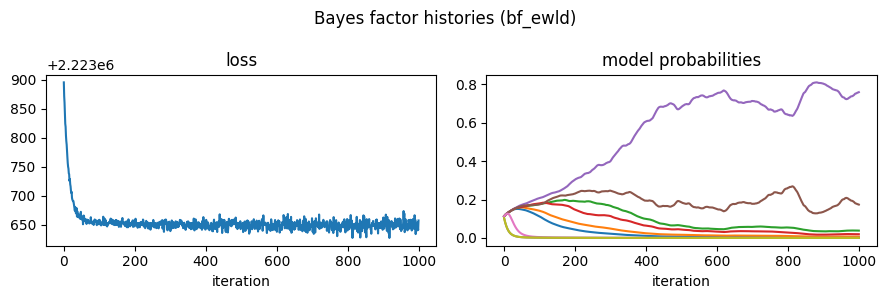

loss variance (last 100 steps): 62.08491484780364


In [43]:
ewld_cmp, ewld_cmp_hist = run_bayes_factors(ewld_obs, ewld_outputs, ewld_chordtypes, nsteps=1_000, lr=0.05, save_as="bf_ewld")

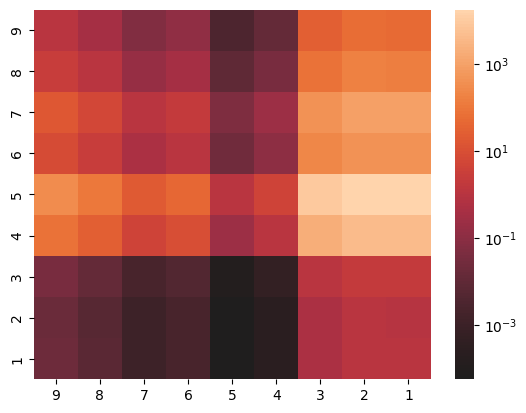

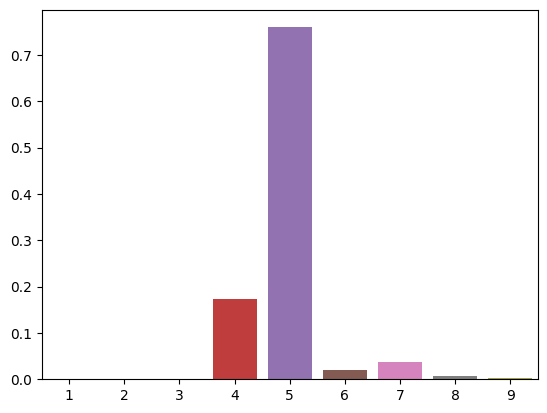

0.01934520896269051

In [44]:
ewld_bfs, ewld_m_params = bf_bayes_factors(ewld_cmp)
plot_bayes_factors(ewld_bfs, ewld_m_params)
ewld_bfs[8,0]

In [45]:
# for script mode
plt.show()